# 22.46 Procesamiento Adaptativo de Señales Aleatorias
## Trabajo Práctico N° 1
## Estimación espectral no-paramétrica
Se busca analizar la señal gravitatoria **GW150914** detectada por el proyecto **LIGO** el 14 de septiembre de 2015. Para ello, se realiza primero un análisis y estudio de la señal capturada por los sensores, y a partir de las conclusiones obtenidas y la información extraída, se propone un filtrado que permita obtener las señales con el menor ruido posible.

#### Grupo N° 1
* Kammann, Lucas Agustín
* Trozzo, Rafael Nicolás
* Davidov, Gonzalo Joaquín
* Farall, Facundo David

In [46]:
import seaborn as sns

In [47]:
sns.set_style('dark')
sns.set_context('paper')
sns.set_palette('flare')

## Descargando muestras de la señal
Se procede a descargar las muestras de la señal obtenidas por los sensores, se descargan con una frecuencia de muestreo $f_s = 4kHz$, en extensión temporal de $32 s$ y $4096 s$.

In [48]:
import wget

In [49]:
import os

In [50]:
# Create a dictionary with filenames
filepath= {
    'H1': {
        '32': '../resources/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5',
        '4096': '../resources/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
    },
    'L1': {
        '32': '../resources/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5',
        '4096': '../resources/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
    }
}

In [51]:
# Create a resources/ folder
! cd .. & mkdir resources

Ya existe el subdirectorio o el archivo resources.


In [52]:
# Download 4096 second data files around GW150914
if not os.path.exists(filepath['H1']['4096']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5
if not os.path.exists(filepath['L1']['4096']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5

In [53]:
# Download 32 second data files around GW150914
if not os.path.exists(filepath['H1']['32']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5
if not os.path.exists(filepath['L1']['32']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5

## Decodificando archivos HDF5
Utilizando la biblioteca **h5py** se decodifican los archivo en formato **HDF5** para tener acceso a las muestras de las señales.

##### Fuentes de información
* https://cplberry.com/tag/losc/
* https://docs.h5py.org/en/stable/index.html
* https://www.gw-openscience.org/static/sample_code/readligo.py

In [54]:
import h5py

In [55]:
def read_data(filename: str) -> tuple:
    """ Extracts sampling information and the signal samples from the HDF5 file obtained
        using LIGO's sensors to detect the gravitational wave.
        @param filename Filename or filepath to read the HDF5 file
        @return (start, ts, sample)
        
        @note The start value returned is in GPS units, and it represents the starting time of the sequence
    """
    # Open the HDF5 file and extract the strain dataset
    file = h5py.File(filename, 'r')
    strain_dataset = file['strain/Strain']
    
    # Read the sampling time and the starting time
    ts = strain_dataset.attrs['Xspacing']
    start = strain_dataset.attrs['Xstart']
    
    # Read the samples
    samples = strain_dataset[:]
    
    return start, ts, samples

In [56]:
def get_event_info(data_start, data_sample_rate, event_start, event_duration):
    """ Get time information of the event, it basically converts the known absolute duration and start of the event
        to a value measured in data samples. Provides an easy way to locate the event in the data.
        @param data_start GPS starting time of the data sequence
        @param data_sample_rate Sampling rate
        @param event_start GPS starting time of the event
        @param event_duration Duration in seconds of the event
        @return (start, duration)
    """
    start = int((event_start - data_start) * data_sample_rate)
    duration = int(event_duration * data_sample_rate)
    return start, duration

In [57]:
# Read H1 data (both 32 and 4096 seconds of duration)
h1_32_start, h1_32_ts, h1_32_samples = read_data(filepath['H1']['32'])
h1_4096_start, h1_4096_ts, h1_4096_samples = read_data(filepath['H1']['4096'])

In [58]:
# Read L1 data (both 32 and 4096 seconds of duration)
l1_32_start, l1_32_ts, l1_32_samples = read_data(filepath['L1']['32'])
l1_4096_start, l1_4096_ts, l1_4096_samples = read_data(filepath['L1']['4096'])

In [59]:
# Define known absolute parameters of the event
event_start = 1126259462
event_duration = 200e-3

# Extract information of the event
h1_32_ev_info = get_event_info(h1_32_start, 1 / h1_32_ts, event_start, event_duration)
h1_4096_ev_info = get_event_info(h1_4096_start, 1 / h1_4096_ts, event_start, event_duration)
l1_32_ev_info = get_event_info(l1_32_start, 1 / l1_32_ts, event_start, event_duration)
l1_4096_ev_info = get_event_info(l1_4096_start, 1 / l1_4096_ts, event_start, event_duration)

# Print event information for each dataset
print('Ubicación y duración del evento')
print(f'Para H1 con 32s -> En {h1_32_ev_info[0]} y dura {h1_32_ev_info[1]} muestras')
print(f'Para H1 con 4096s -> En {h1_4096_ev_info[0]} y dura {h1_4096_ev_info[1]} muestras')
print(f'Para L1 con 32s -> En {l1_32_ev_info[0]} y dura {l1_32_ev_info[1]} muestras')
print(f'Para L1 con 4096s -> En {l1_4096_ev_info[0]} y dura {l1_4096_ev_info[1]} muestras')

Ubicación y duración del evento
Para H1 con 32s -> En 61440 y dura 819 muestras
Para H1 con 4096s -> En 8384512 y dura 819 muestras
Para L1 con 32s -> En 61440 y dura 819 muestras
Para L1 con 4096s -> En 8384512 y dura 819 muestras


## Visualización de señales originales
En esta sección se visualizan las señales originales obtenidas a partir de los sensores.

In [60]:
import matplotlib.pyplot as plt

In [61]:
import numpy as np

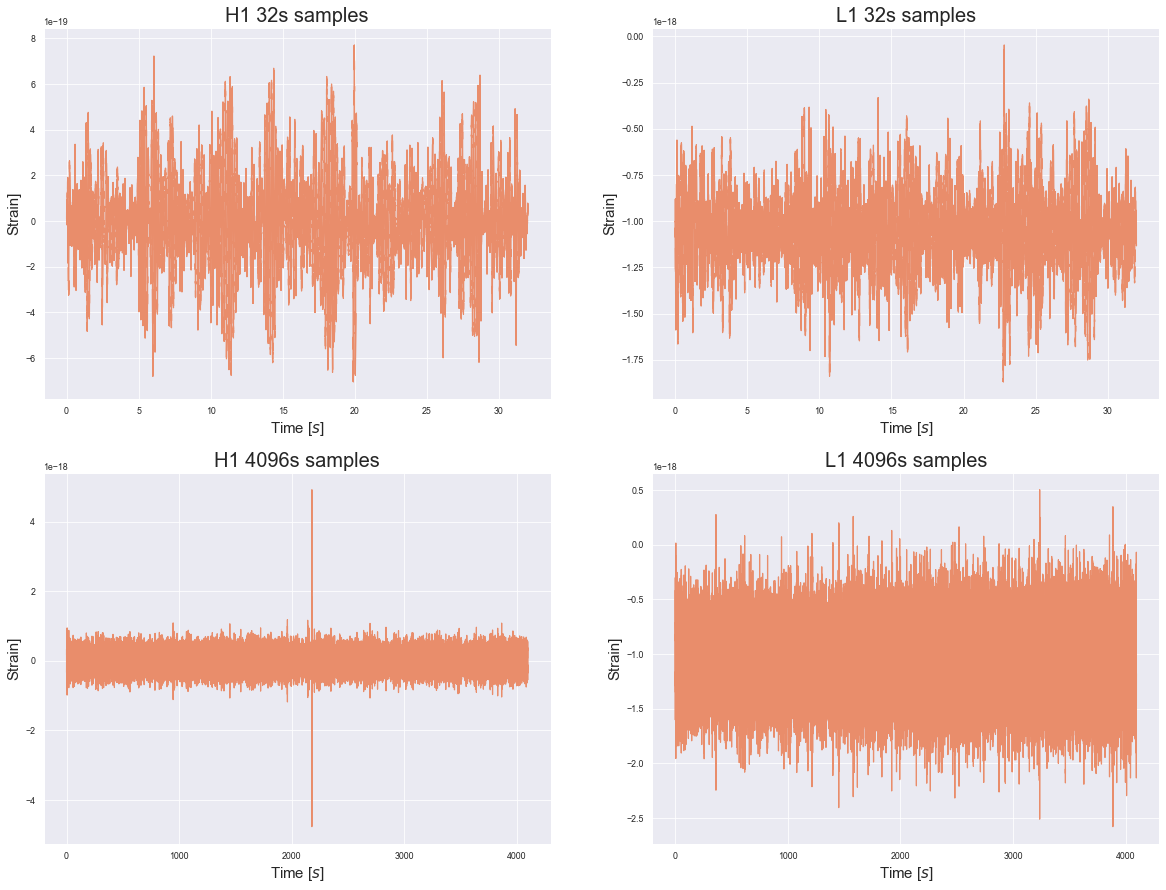

In [62]:
# Create four plotting areas to show L1 and H1 in both durations (32 and 4096 seconds)
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Plot data
ax[0, 0].plot(np.arange(0, len(h1_32_samples) * h1_32_ts, h1_32_ts), h1_32_samples)
ax[0, 0].set_title('H1 32s samples', fontsize=20)
ax[0, 0].set_ylabel('Strain]', fontsize=15)
ax[0, 0].set_xlabel('Time [$s$]', fontsize=15)
ax[0, 0].grid()

ax[1, 0].plot(np.arange(0, len(h1_4096_samples) * h1_4096_ts, h1_4096_ts), h1_4096_samples)
ax[1, 0].set_title('H1 4096s samples', fontsize=20)
ax[1, 0].set_ylabel('Strain]', fontsize=15)
ax[1, 0].set_xlabel('Time [$s$]', fontsize=15)
ax[1, 0].grid()

ax[0, 1].plot(np.arange(0, len(l1_32_samples) * l1_32_ts, l1_32_ts), l1_32_samples)
ax[0, 1].set_title('L1 32s samples', fontsize=20)
ax[0, 1].set_ylabel('Strain]', fontsize=15)
ax[0, 1].set_xlabel('Time [$s$]', fontsize=15)
ax[0, 1].grid()

ax[1, 1].plot(np.arange(0, len(l1_4096_samples) * l1_4096_ts, l1_4096_ts), l1_4096_samples)
ax[1, 1].set_title('L1 4096s samples', fontsize=20)
ax[1, 1].set_ylabel('Strain]', fontsize=15)
ax[1, 1].set_xlabel('Time [$s$]', fontsize=15)
ax[1, 1].grid()

# Show
plt.show()

## Escuchando el audio

In [63]:
from IPython.display import Audio

In [64]:
Audio(l1_32_samples, rate=(1 / l1_32_ts), autoplay=True)

## Estimación espectral
A lo expuesto en la sección de estacionariedad, es necesario agregar que la calidad de la estimación también se encuentra sujeta al método empleado para ello, por ende en esta sección se exploran diversas alternativas o métodos, y se realizan comparaciones cualitativas.

In [65]:
from scipy import signal

In [66]:
from scipy import fft

In [67]:
def plot_single_asd(psd, fs, title):
    """ Plot the Amplitude Spectral Density (ASD) 
        @param psd Power spectral density
        @param fs Sampling frequency
        @param title Title of the plot
    """
    # Use only the positive side of the spectrum
    psd = psd[0:len(psd) // 2 + 1]
    
    # Plot the amplitude spectral density
    plt.figure(figsize=(18, 10))
    plt.loglog(np.linspace(0, fs / 2, num=len(psd)), np.sqrt(psd))
    plt.title(title, fontsize=18)
    plt.xlabel('Frequency [Hz]', fontsize=15)
    plt.ylabel('ASD [$\\frac{strain}{\sqrt{Hz}}$]', fontsize=15)
    plt.autoscale(True, axis='y')
    plt.show()

In [68]:
def plot_dual_asd(l1_psd, h1_psd, fs, title):
    """ Plot the Amplitude Spectral Density (ASD)
        @param l1_psd L1 power spectral density 
        @param h1_psd H1 power spectral density
        @param fs Sampling frequency
        @param title Title of the plot
    """
    # Use only the positive side of the spectrum
    l1_psd = l1_psd[0:len(l1_psd) // 2 + 1]
    h1_psd = h1_psd[0:len(h1_psd) // 2 + 1]
    
    # Plot the amplitude spectral density
    fig, ax = plt.subplots(2, 1, figsize=(18,14), sharey=True)
    fig.suptitle(title, fontsize=20)
    
    ax[0].loglog(np.linspace(0, fs / 2, num=len(l1_psd)), np.sqrt(l1_psd))
    ax[0].set_title('L1', fontsize=18)
    ax[0].set_xlabel('Frequency [Hz]', fontsize=15)
    ax[0].set_ylabel('ASD [$\\frac{strain}{\sqrt{Hz}}$]', fontsize=15)
    ax[0].autoscale(True, axis='y')
    ax[0].grid(which='both', axis='x')
    ax[0].grid(which='major', axis='y')
    ax[0].set_xlim(left=10)
    
    ax[1].loglog(np.linspace(0, fs / 2, num=len(h1_psd)), np.sqrt(h1_psd))
    ax[1].set_title('H1', fontsize=18)
    ax[1].set_xlabel('Frequency [Hz]', fontsize=15)
    ax[1].autoscale(True, axis='y')
    ax[1].grid(which='both', axis='x')
    ax[1].grid(which='major', axis='y')
    ax[1].set_xlim(left=10)
    
    plt.show()

### Periodograma

In [69]:
def periodogram(x: np.array, window: str = 'boxcar', one_sided: bool = True) -> np.array:
    """ Estimate a signal's power spectrum with the discrete periodogram.
        @param x          Samples of the random signal realization
        @param window     Type of window
        @param one_sided  Whether to return only the real frequencies [0,pi] or all of them [0,2pi]
        @return Power spectrum density estimation
    """
    # Validate the type of window
    if type(window) is not str:
        raise ValueError('Window must be a string value, unexpected type of data')
    
    # Validate signal samples
    if type(x) is not np.array and type(x) is not np.ndarray:
        raise ValueError('Signal samples must be np.array, unexpected type of data')
    elif x.ndim > 1:
        raise ValueError('The signal samples argument must be 1D')
        
    # Validate the one sided parameter
    if type(one_sided) is not bool:
        raise ValueError('Argument one_sided must be boolean, unexpected type of data')
    
    # Obtain amount of samples
    N = len(x)
    
    # Apply window to input samples
    w = signal.windows.get_window(window, N)
    v = x * w
    
    # Normalize window energy
    scale = np.sum(w * w) / N
        
    # Compute windowed data FFT. With norm="ortho" we don't need to divide by N.
    V = fft.fft(v, norm="ortho")
    
    # Square the elements
    Rx = np.abs(V) ** 2 / scale

    # If one sided, use only the real frequencies with the same energy
    if one_sided:
        Rx = 2 * Rx[0:N // 2 + 1]
    
    return Rx

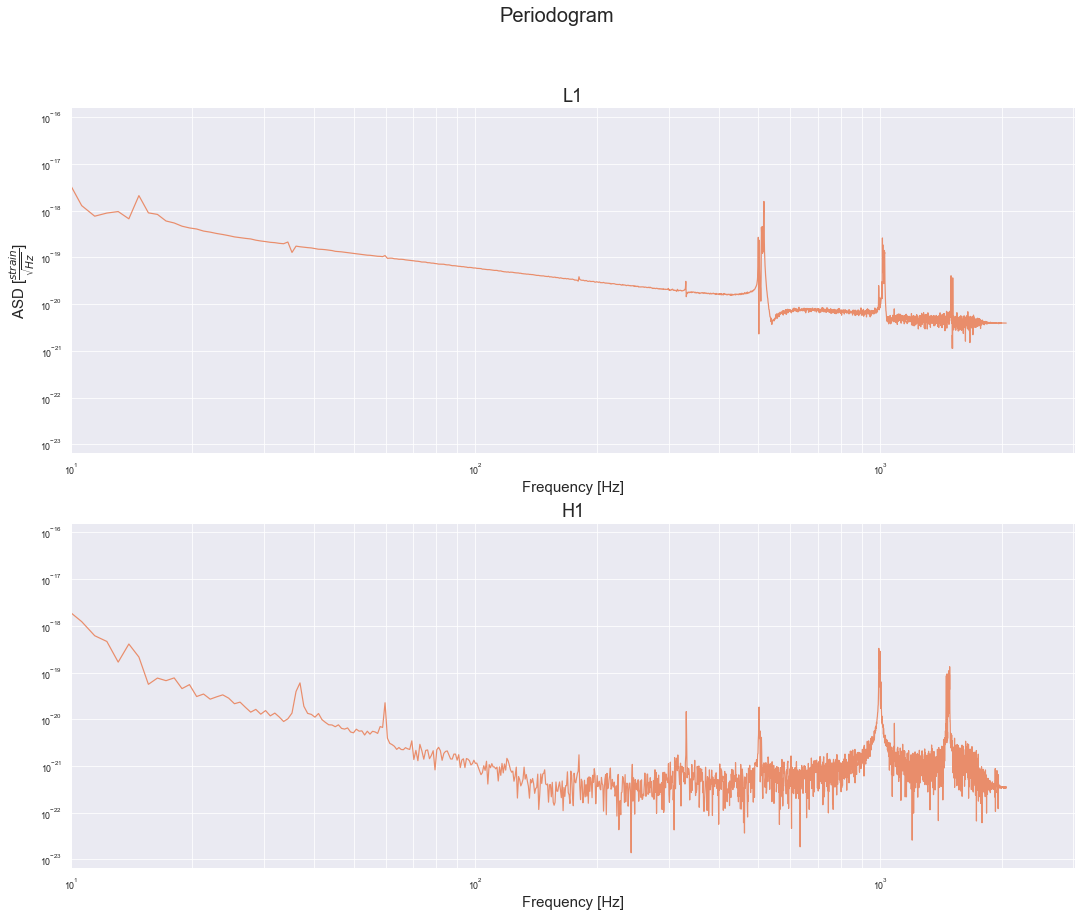

In [70]:
# Compute the periodogram and plot it
N = 5000
h1_32_psd = periodogram(h1_32_samples[0:N], window='boxcar', one_sided=False)
l1_32_psd = periodogram(l1_32_samples[0:N], window='boxcar', one_sided=False)
plot_dual_asd(l1_32_psd, h1_32_psd, 1 / h1_32_ts, 'Periodogram')

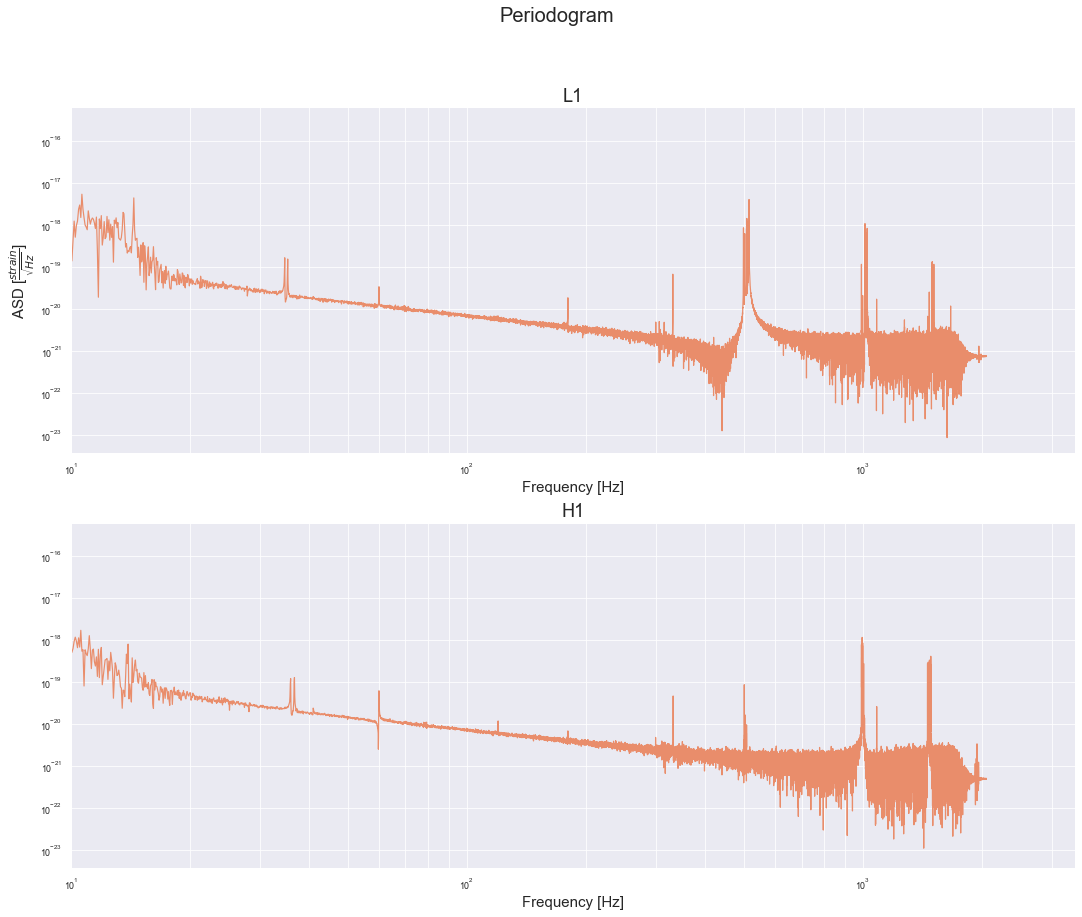

In [71]:
# Compute the periodogram and plot it
N = 61000
h1_32_psd = periodogram(h1_32_samples[0:N], window='boxcar', one_sided=False)
l1_32_psd = periodogram(l1_32_samples[0:N], window='boxcar', one_sided=False)
plot_dual_asd(l1_32_psd, h1_32_psd, 1 / h1_32_ts, 'Periodogram')

### Conclusión
Para la elección de la cantidad de muestras en la estimación de la densidad espectral de amplitud, usando el periodograma, se busca usar la mayor cantidad posible para tener una resolución espectral superior, pero con la limitación de no incluir el evento gravitatorio dentro de la secuencia dado que se busca estimar el espectro de potencia del ruido de los sensores. No se tuvieron en cuenta como criterios de decisión los costos computacionales dado que no presentan una limitación en este contexto. Esto se puede observar en las estimaciones presentadas anteriormente para una cantidad de muestras de $N = 5000$ y $N  = 61000$.

### Periodogram smoothing

In [72]:
def periodogram_smoothing(x: np.array, L: int, window='triang'):
    ''' Compute periodogram using periodogram smoothing method for the given signal.
        @param  x       Signal to estimate its Power Spectrum Density.
        @param  L       Length of the window to apply. Larger values produce periodograms with higher spectral definition, but less averaging, and vice versa.
        @param  window  Window to use for the periodogram smoothing algorithm. Accepted values are 'triang' and 'parzen'.
        @return         Numpy array with the values of the PSD, non shifted (as it comes from the FFT).
    '''
    N = len(x)
    rxx = signal.correlate(x, x, method='fft')
    rxx /= N
    w = np.concatenate((np.zeros(int(N-L-1)), getattr(signal, window)(2 * L + 1), np.zeros(int(N-L-1))))
    rxx_w = np.multiply(rxx, w)
    Pxx_w = np.abs(fft.fft(rxx_w))
    return Pxx_w

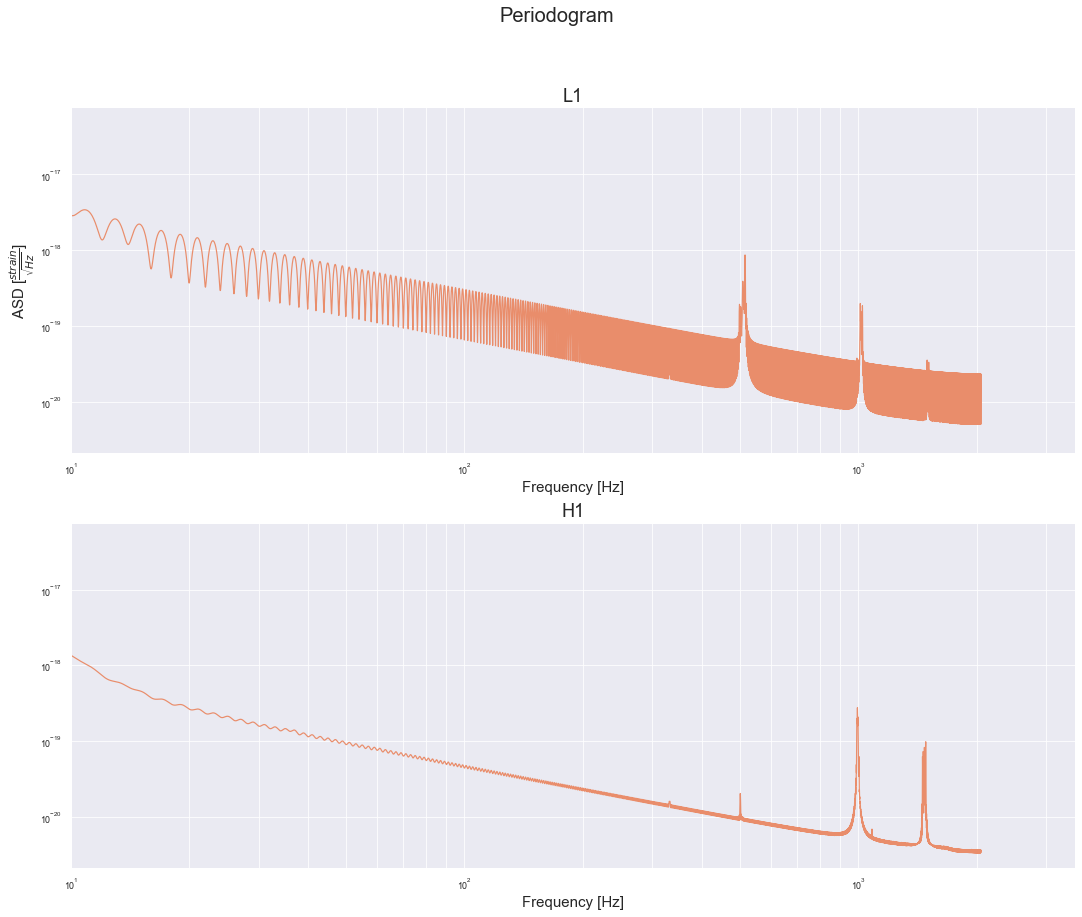

In [73]:
# Compute the periodogram and plot it
N = 61000
L = 2048
window = 'triang'
h1_32_psd_smoothing = periodogram_smoothing(h1_32_samples[0:N], L, window=window)
l1_32_psd_smoothing = periodogram_smoothing(l1_32_samples[0:N], L, window=window)
plot_dual_asd(l1_32_psd_smoothing, h1_32_psd_smoothing, 1 / h1_32_ts, 'Periodogram')

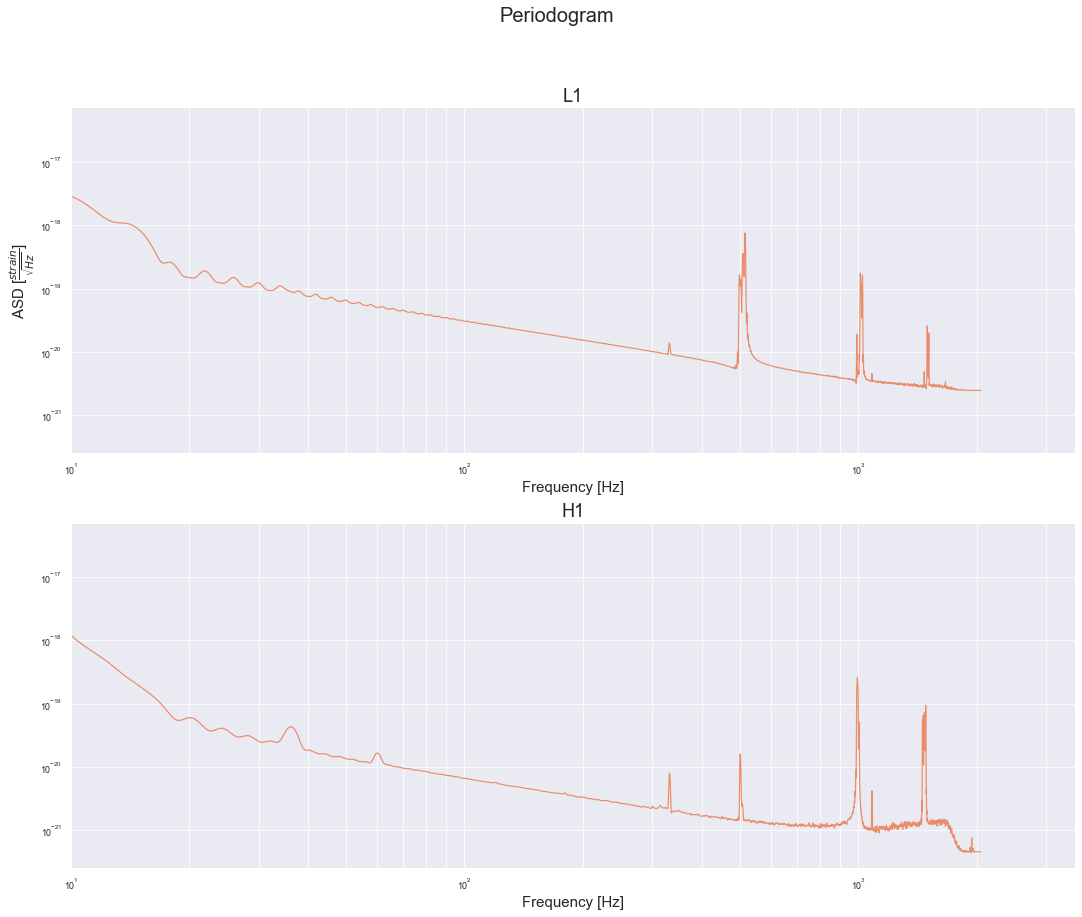

In [74]:
# Compute the periodogram and plot it
N = 61000
L = 2048
window = 'parzen'
h1_32_psd_smoothing = periodogram_smoothing(h1_32_samples[0:N], L, window=window)
l1_32_psd_smoothing = periodogram_smoothing(l1_32_samples[0:N], L, window=window)
plot_dual_asd(l1_32_psd_smoothing, h1_32_psd_smoothing, 1 / h1_32_ts, 'Periodogram')

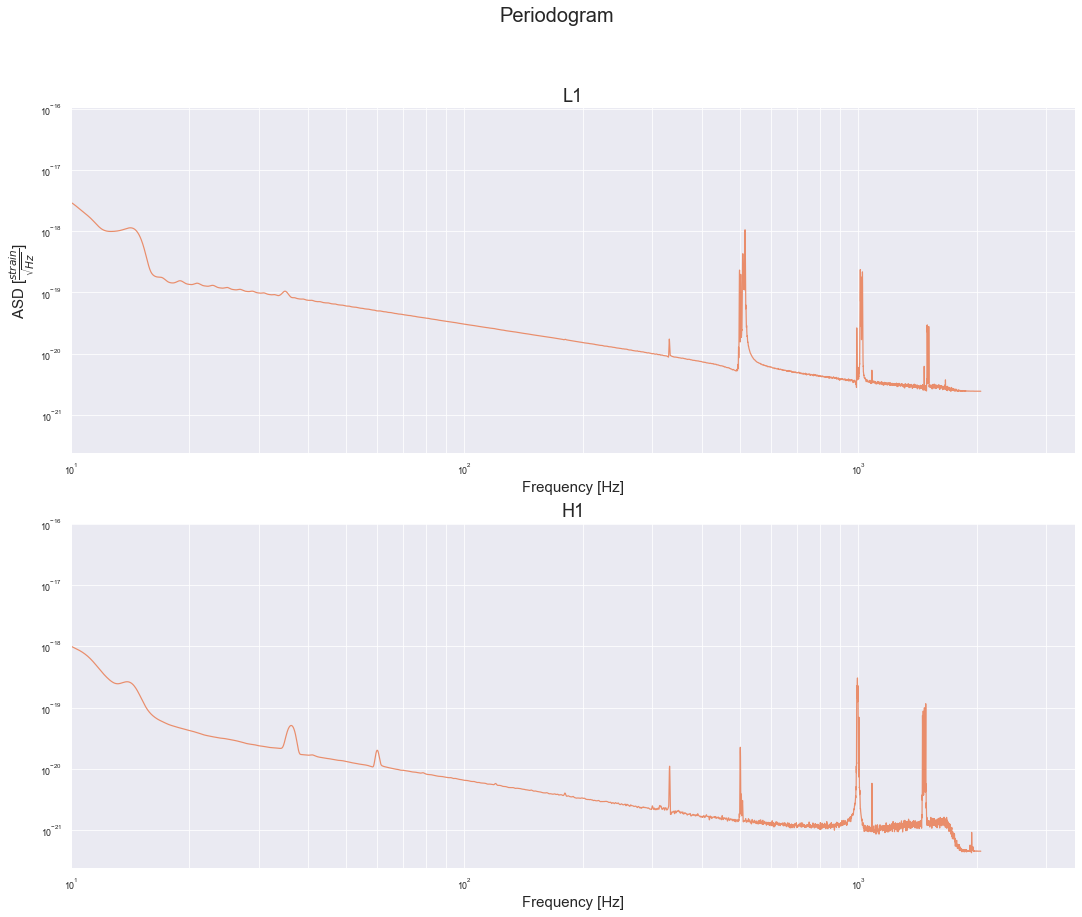

In [75]:
# Compute the periodogram and plot it
N = 61000
L = 4096
window = 'parzen'
h1_32_psd_smoothing = periodogram_smoothing(h1_32_samples[0:N], L, window=window)
l1_32_psd_smoothing = periodogram_smoothing(l1_32_samples[0:N], L, window=window)
plot_dual_asd(l1_32_psd_smoothing, h1_32_psd_smoothing, 1 / h1_32_ts, 'Periodogram')

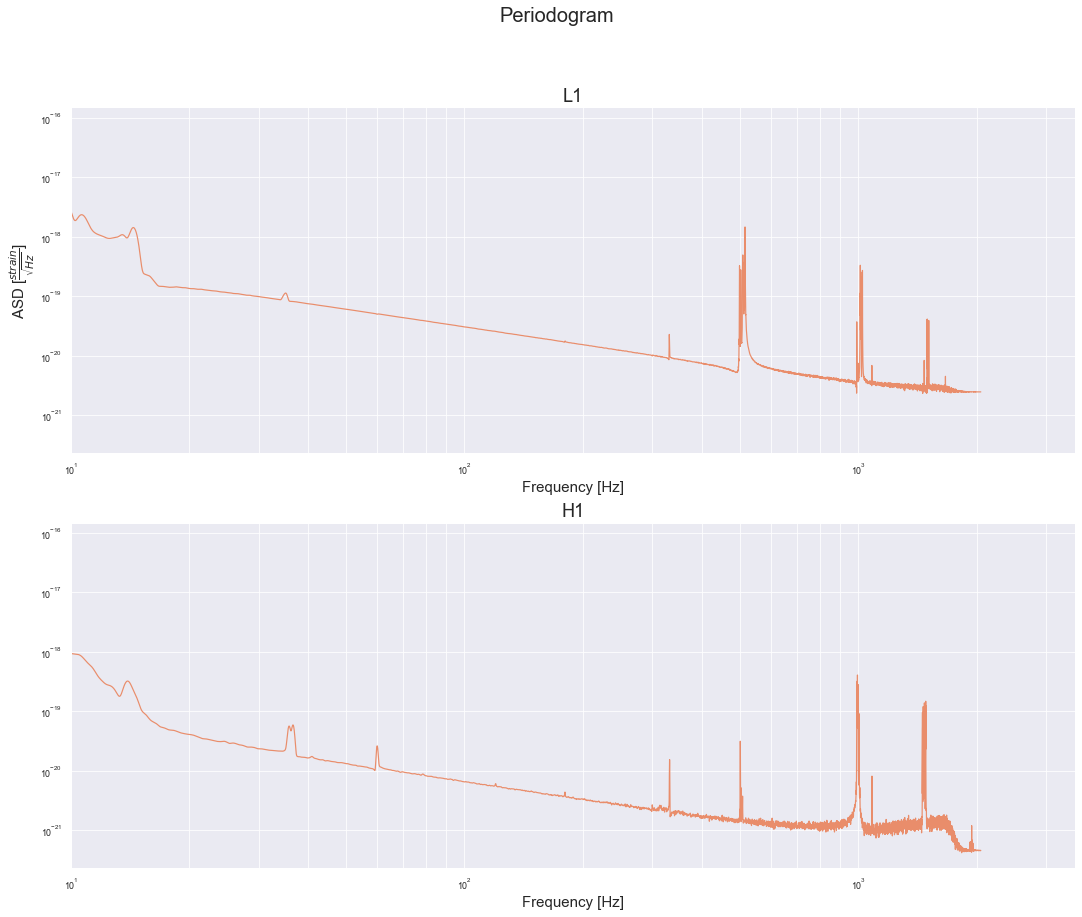

In [76]:
# Compute the periodogram and plot it
N = 61000
L = 8192
window = 'parzen'
h1_32_psd_smoothing = periodogram_smoothing(h1_32_samples[0:N], L, window=window)
l1_32_psd_smoothing = periodogram_smoothing(l1_32_samples[0:N], L, window=window)
plot_dual_asd(l1_32_psd_smoothing, h1_32_psd_smoothing, 1 / h1_32_ts, 'Periodogram')

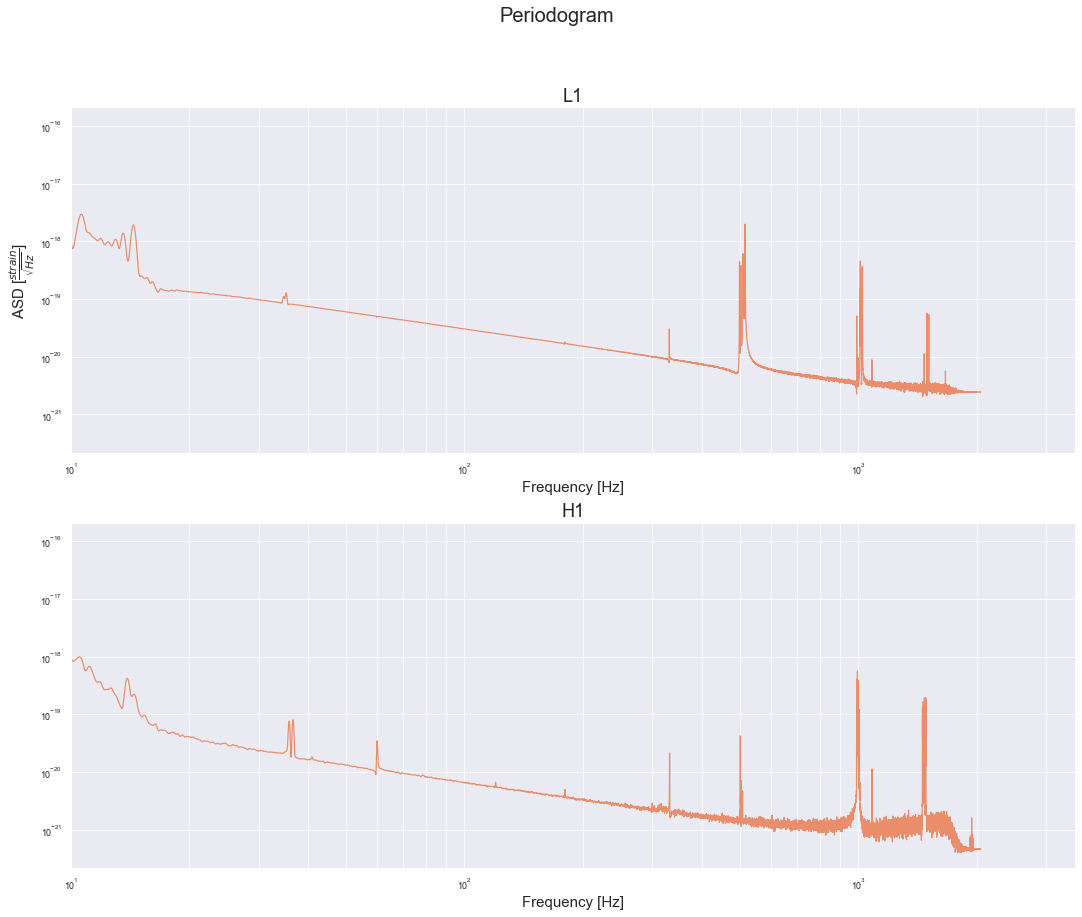

In [77]:
# Compute the periodogram and plot it
N = 61000
L = 16384
window = 'parzen'
h1_32_psd_smoothing = periodogram_smoothing(h1_32_samples[0:N], L, window=window)
l1_32_psd_smoothing = periodogram_smoothing(l1_32_samples[0:N], L, window=window)
plot_dual_asd(l1_32_psd_smoothing, h1_32_psd_smoothing, 1 / h1_32_ts, 'Periodogram')

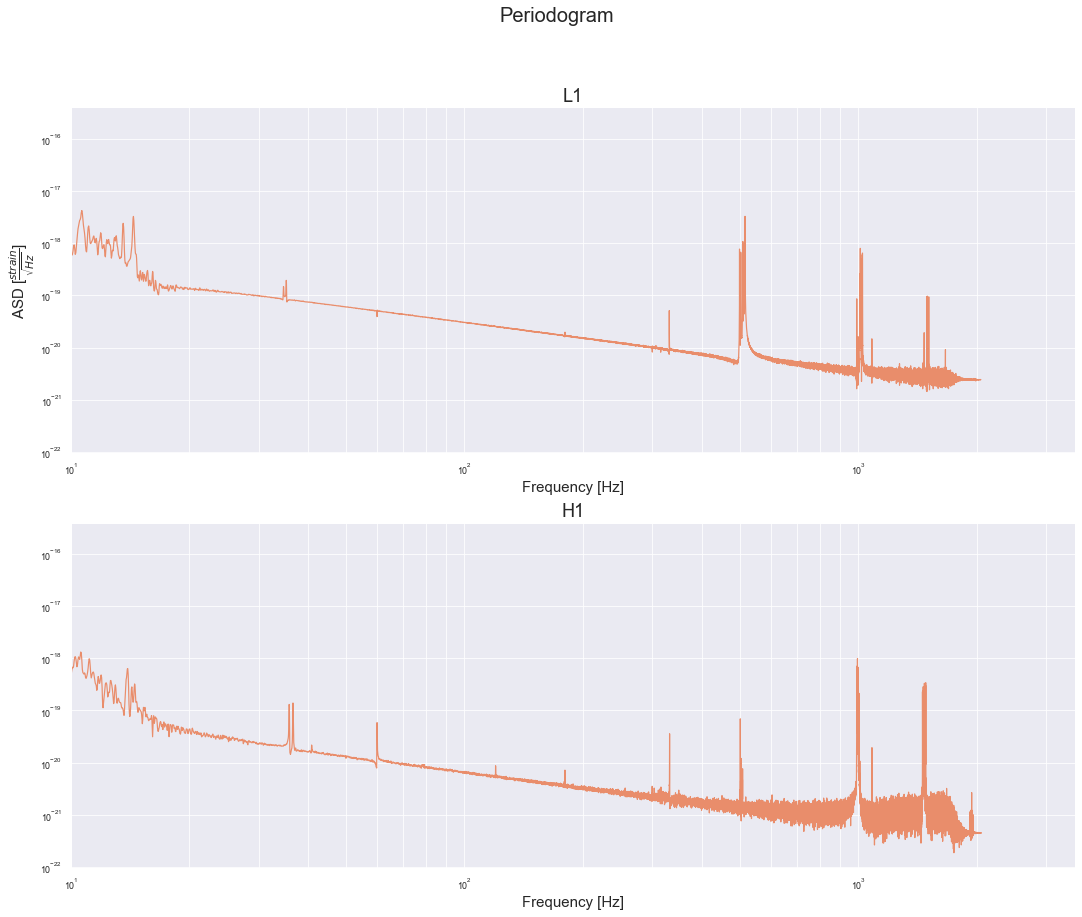

In [78]:
# Compute the periodogram and plot it
N = 61000
L = N-1
window = 'parzen'
h1_32_psd_smoothing = periodogram_smoothing(h1_32_samples[0:N], L, window=window)
l1_32_psd_smoothing = periodogram_smoothing(l1_32_samples[0:N], L, window=window)
plot_dual_asd(l1_32_psd_smoothing, h1_32_psd_smoothing, 1 / h1_32_ts, 'Periodogram')

### Conclusión
En primer lugar, se probaron dos ventanas posibles (la ventana Triangular y la ventana de Parzen), y en ambos casos no se pudo observar una clara presencia del espectro característico de shotnoise. Además, en el caso de la ventana Triangular se observa un claro efecto del leakage espectral. Se intentó seleccionar un valor de $ L $ pequeño ya que proporciona mayor reducción de esta potencia de ruido, pero los lóbulos son más anchos, perdiendo resolución espectral en caso de que dos picos queden dentro de un mismo lóbulo. En este caso, como resultado de la observación de los resultados obtenidos, se decidió que el mejor balance entre la varianza del estimador y la resolución espectral se da con $ L = 4096 $.

### Periodogram averaging

In [79]:
def periodogram_averaging(x: np.array, window_size: int, overlap: float = 0.0, window: str = 'boxcar', one_sided: bool = False) -> np.array:
    """ Apply the welch-bartlett method (averaging periodograms) to estimate a signal's power spectrum.
        @param x Samples of the random signal realization    
        @param window_size Size of the window
        @param overlap Overlapping factor [0.0, 1.0)  
        @param window Type of window
        @param one_sided One sided
        @return Power spectrum density estimation
    """
    # Validate the type of window
    if type(window) is not str:
        raise ValueError('Window must be a string value, unexpected type of data')
    
    # Validate signal samples
    if type(x) is not np.array and type(x) is not np.ndarray:
        raise ValueError('Signal samples must be np.array, unexpected type of data')
    elif x.ndim > 1:
        raise ValueError('The signal samples argument must be 1D')
        
    # Validate the window size
    if type(window_size) is not int:
        raise ValueError('Window size must be an integer value, unexpected type of data')
    elif window_size < 1 or window_size >= len(x):
        raise ValueError('Window size out of range')
    
    # Validate the overlapping
    if type(overlap) is not float:
        raise ValueError('The overlap must be a decimal value, unexpected type of data')
    elif overlap < 0.0 or overlap >= 1.0:
        raise ValueError('Overlapping factor out of range')
    
    # Compute algorithm parameters based on the arguments passed to the function
    N = len(x)
    L = window_size
    D = int(L * (1 - overlap))
    K = int((N - L + 1) / D) + 1
    
    # Create the periodogram matrix and compute i-th segment periodogram
    periodograms = np.zeros((K, (L // 2 + 1 if one_sided else L)))
    segment = np.zeros((L))
    for k in range(K):
        segment = x[k * D:k * D + L]
        periodograms[k,:] = periodogram(segment, window=window, one_sided=one_sided)
    # Squash and average periodograms
    return periodograms.sum(axis=0) / K

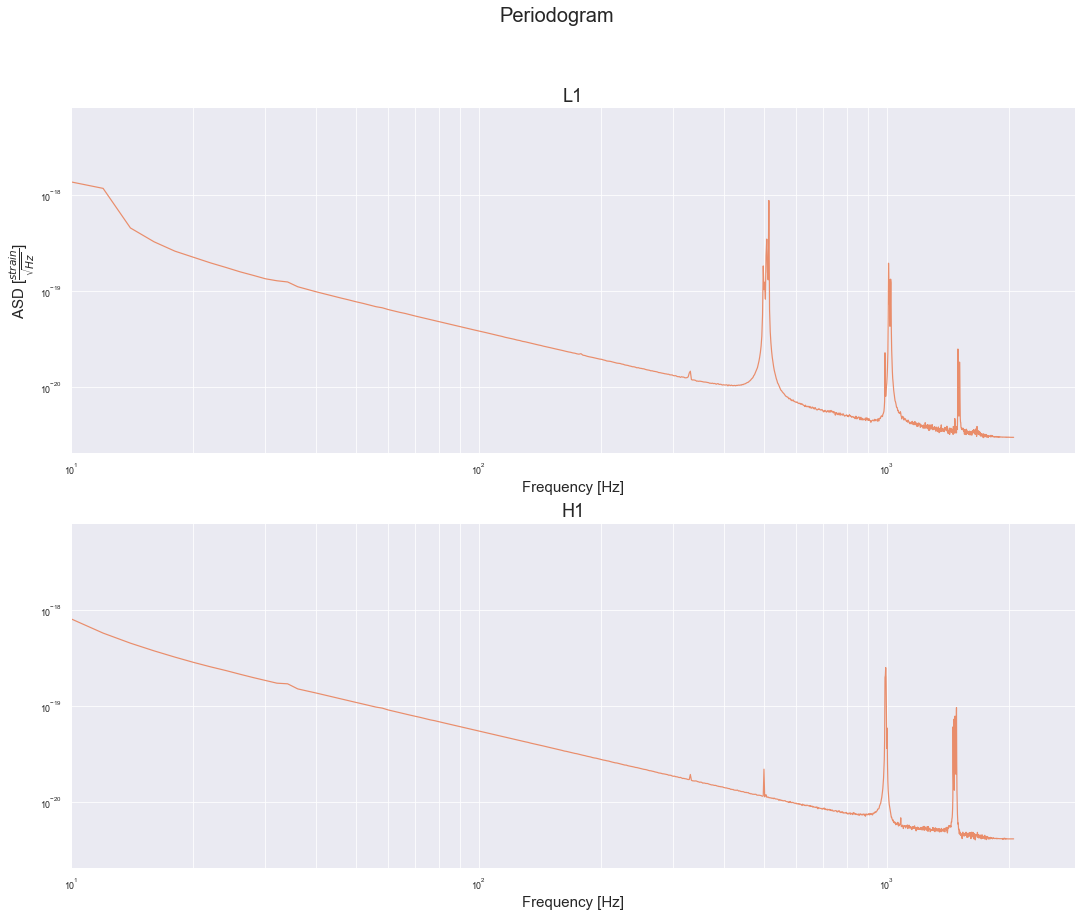

In [80]:
# Set testbench parameters
N = 61000
L = 2048
overlapping=0.0
window='boxcar'

# Compute and plot estimation
h1_32_psd_averaging = periodogram_averaging(h1_32_samples[0:N], L, overlapping, window)
l1_32_psd_averaging = periodogram_averaging(l1_32_samples[0:N], L, overlapping, window)
plot_dual_asd(l1_32_psd_averaging[1:], h1_32_psd_averaging[1:], 1 / h1_32_ts, 'Periodogram')

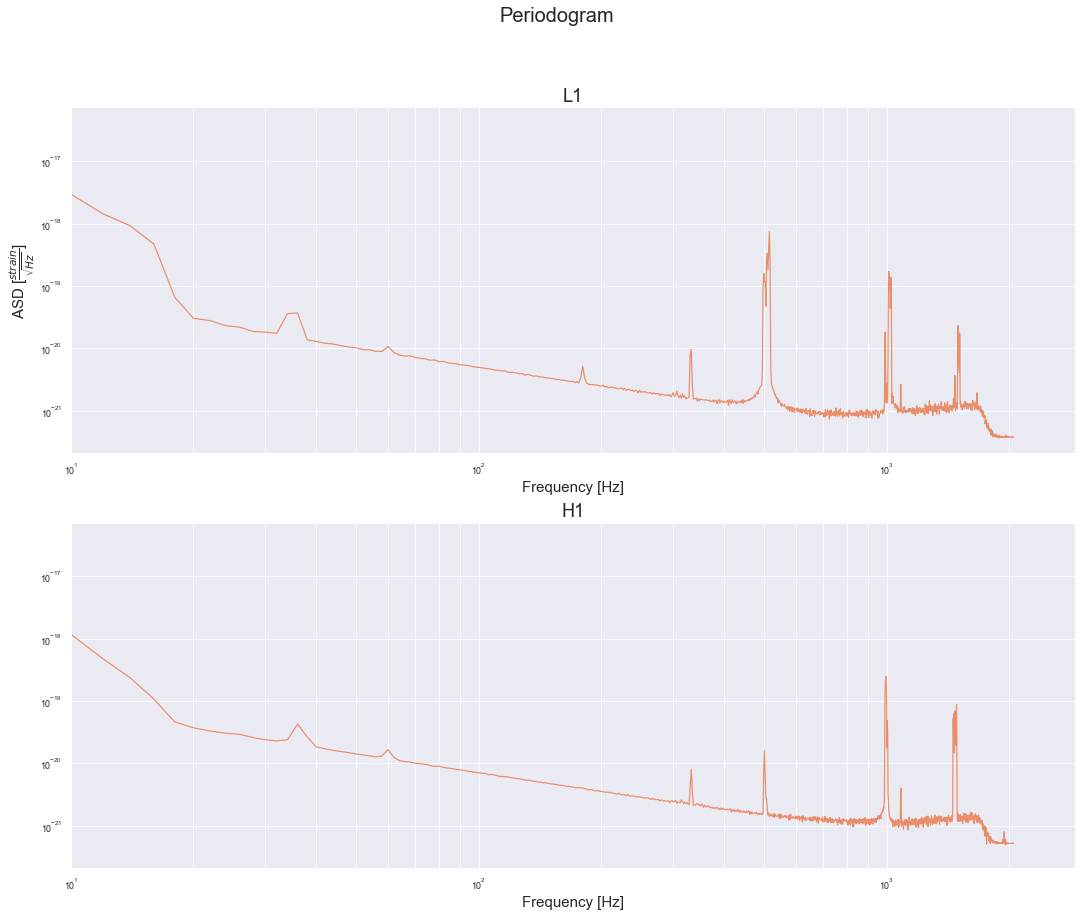

In [81]:
# Set testbench parameters
N = 61000
L = 2048
overlapping=0.0
window='hamming'

# Compute and plot estimation
h1_32_psd_averaging = periodogram_averaging(h1_32_samples[0:N], L, overlapping, window)
l1_32_psd_averaging = periodogram_averaging(l1_32_samples[0:N], L, overlapping, window)
plot_dual_asd(l1_32_psd_averaging, h1_32_psd_averaging, 1 / h1_32_ts, 'Periodogram')

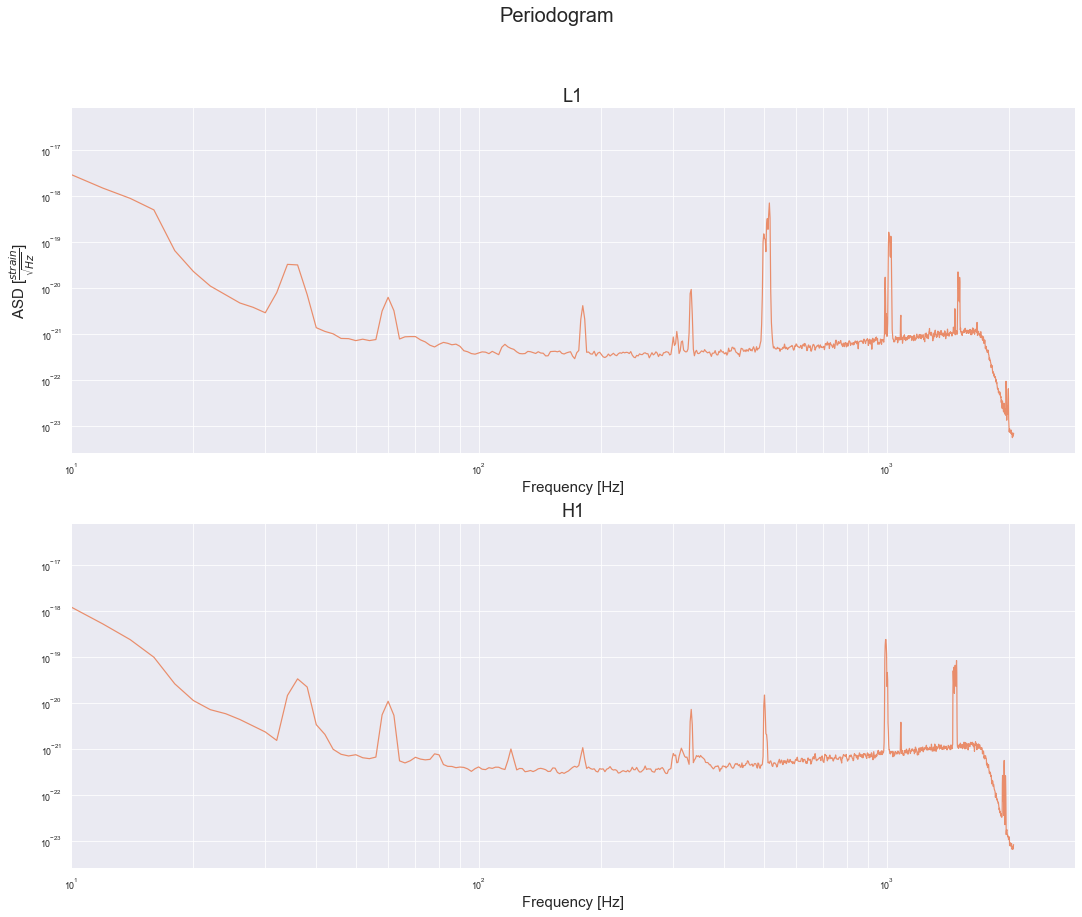

In [82]:
# Set testbench parameters
N = 61000
L = 2048
overlapping=0.0
window='hann'

# Compute and plot estimation
h1_32_psd_averaging = periodogram_averaging(h1_32_samples[0:N], L, overlapping, window)
l1_32_psd_averaging = periodogram_averaging(l1_32_samples[0:N], L, overlapping, window)
plot_dual_asd(l1_32_psd_averaging, h1_32_psd_averaging, 1 / h1_32_ts, 'Periodogram')

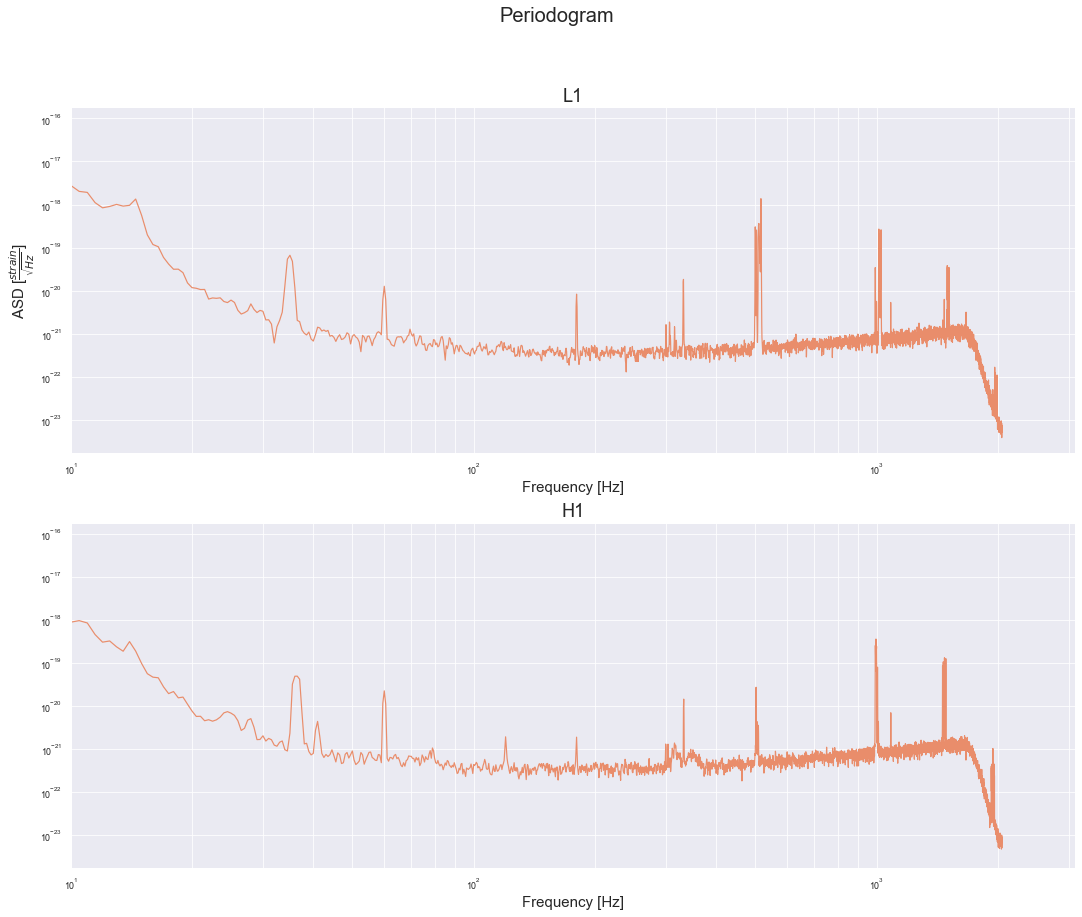

In [83]:
# Set testbench parameters
N = 61000
L = 8192
overlapping=0.0
window='hann'

# Compute and plot estimation
h1_32_psd_averaging = periodogram_averaging(h1_32_samples[0:N], L, overlapping, window)
l1_32_psd_averaging = periodogram_averaging(l1_32_samples[0:N], L, overlapping, window)
plot_dual_asd(l1_32_psd_averaging, h1_32_psd_averaging, 1 / h1_32_ts, 'Periodogram')

## Conclusión
Para todos los gráficos obtenidos de la estimación de la densidad espectral de amplitud, se puede observar que para las mayores frecuencias ocurre una caída abrupta de la amplitud, se atribuye tal caida a la presencia de un filtro antialias durante la adquisición de datos. Dado que LIGO advierte que el ruido de fondo está contaminado con **shotnoise**, esta información o conocimiento a priori es de utilidad para saber qué tipo de espectro debería obtenerse como resultado de la estimación espectral. Por esto último, se fueron utilizando diferentes ventanas hasta encontrar que con la ventana de Hann el espectro de amplitudes se asemeja al espectro del shotnoise. Finalmente, se buscó un valor de L muestras para obtener una adecuada resolución espectral y una varianza en la estimación aceptable.

La razón de por qué sólo se puede observar correctamente el espectro utilizando la ventana de Hann, es que los estimadores empleados son sesgados o poseen bias, por ende la estimación nunca se acerca al espectro verdadero sino a una versión afectada por el espectro de la ventana. Y, particularmente, la ventana de Hann posee la menor cantidad de lóbulos secundarios, lo cual minimiza el efecto del **leakage espectral**. Es decir, el problema principal que poseen las ventanas Rectangular y de Hamming, es que el leakage espectral que poseen no permite observar adecuadamente el espectro original de la señal.

## Estimación final
En primer lugar, se rechaza utilizar el periodograma dado que es un estimador muy ruidoso, como puede ser observado a partir de los resultados obtenidos. En segundo lugar, se descarta el uso del periodogram smoothing, dado que para todas las ventanas aptas en esa técnica, hay una fuerte presencia de leakage espectral que impide observar correctamente el espectro). Finalmente, se escoge utilizar como técnica de estimación el periodogram averaging, utilizando la ventana de Hann.

Para obtener estas conclusiones, fue necesario partir del conocimiento previo de que el ruido de fondo está mayoritariamente contaminado con shotnoise.

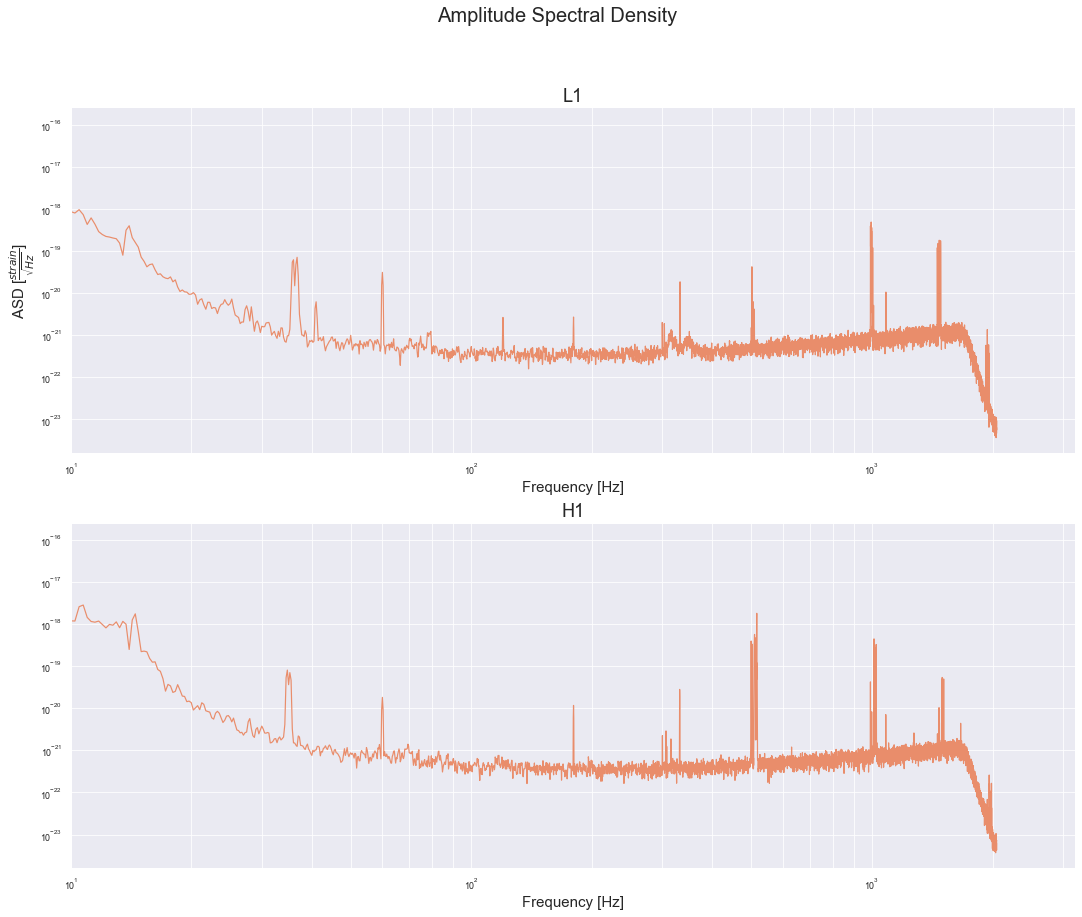

In [84]:
# Chosen estimation parameters
N = 61000
L = 16384
overlapping=0.5
window='hann'

# Compute and plot estimation
h1_32_psd = periodogram_averaging(h1_32_samples[0:N], L, overlapping, window)
l1_32_psd = periodogram_averaging(l1_32_samples[0:N], L, overlapping, window)
plot_dual_asd(h1_32_psd, l1_32_psd, 1 / h1_32_ts, 'Amplitude Spectral Density')

## Comparación de espectros
# TODO!

## Estacionariedad
Para la síntesis de un procesamiento adecuado de las señales gravitatorias es necesario poseer más información de la situación, para lo cual es deseable obtener la densidad espectral de potencia del ruido. Para esto último, es necesario asumir un modelo teórico que describe al ruido como un proceso aleatorio que se entiende como un ensamble infinito de señales de las cuales en la realidad física se observa una única realización. Dado que no se tiene acceso a la realidad subyacente, con la información incompleta que se posee sólo es posible estimar cómo podría ser el espectro del ruido. La calidad de esta estimación está principalmente gobernada por el carácter de ergodicidad del proceso subyacente, esto quiere decir que si tal proceso fuera ergódico, conocer una única realización es suficiente información para conocer su espectro, ya que es altamente representativa de todo el ensamble. No obstante, no se sabe si el proceso es efectivamente ergódico y aunque lo fuera no se conoce la realización, sino un fragmento de ella, por ende siempre se obtiene una estimación ruidosa.

En conclusión, es condición necesaria que el proceso aleatorio sea estacionario en sentido amplio (WSS) para que sea ergódico y obtener una mejor calidad en la estimación. En esta sección nos proponemos validar tal estacionariedad a partir de las muestras obtenidas.

Se investigaron diferentes métodos para poder estudiar la estacionariedad de la señal o proceso, en las fuentes que se enumeran a continuación,
* https://machinelearningmastery.com/time-series-data-stationary-python/
* https://towardsdatascience.com/detecting-stationarity-in-time-series-data-d29e0a21e638
* https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
* https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/
* https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results
* https://stats.stackexchange.com/questions/18133/selecting-regression-type-for-dickey-fuller-test

In [85]:
from scipy import signal

In [86]:
def signal_segmentation(x: np.array, segment_size: int, overlap: float = 0.0) -> np.array:
    """ Extracts segments of a signal to apply block or window based processing algorithms
        @param x Samples of the random signal realization    
        @param segment_size Size of the segment
        @param overlap Overlapping factor [0.0, 1.0)  
        @return Matrix (segment count x segment size) 
    """
    # Validate signal samples
    if type(x) is not np.array and type(x) is not np.ndarray:
        raise ValueError('Signal samples must be np.array, unexpected type of data')
    elif x.ndim > 1:
        raise ValueError('The signal samples argument must be 1D')
        
    # Validate the window size
    if type(segment_size) is not int:
        raise ValueError('Window size must be an integer value, unexpected type of data')
    elif segment_size < 1 or segment_size >= len(x):
        raise ValueError('Window size out of range')
    
    # Validate the overlapping
    if type(overlap) is not float:
        raise ValueError('The overlap must be a decimal value, unexpected type of data')
    elif overlap < 0.0 or overlap >= 1.0:
        raise ValueError('Overlapping factor out of range')
        
    # Compute parameters for segmentation
    N = len(x)
    L = segment_size
    D = int(L * (1 - overlap))
    K = int((N - L + 1) / D) + 1
    
    # Create the periodogram matrix and compute i-th segment periodogram
    segments = np.zeros((K, L))
    for k in range(K):
        segments[k,:] = x[k * D:k * D + L]
    return segments

In [87]:
def signal_statistics(x: np.array, fs: float, interval_size: int, segment_size: int, overlap: float):
    """ Shows statistical information of a random signal. It partitions the signal into intervals (of interval_size) and plots the
        histogram and power spectrum density estimation for each interval. All plots are overlapped to allow easy comparation of the results
        for each interval, as a way of testing the signal's stationarity.
        @param x Samples 
        @param fs Sampling frequency
        @param interval_size Size of the interval
        @param segment_size Size of the segment used in periodogram averaging
        @param overlap Overlappig factor used in periodogram averaging
    """
    # Segmentation of the signal
    segments = signal_segmentation(x, interval_size)
    
    # Periodogram averaging estimation
    periodograms = np.apply_along_axis(lambda s: periodogram_averaging(s, segment_size, window='hann', one_sided=True), axis=1, arr=segments)

    # Plotting the psd and the distribution
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    ax[0].loglog(np.arange(0, fs / 2, (fs / 2) / periodograms.shape[1]), np.sqrt(periodograms.transpose()))
    ax[0].set_title('Power spectrum density estimation', fontsize=20)
    ax[0].set_xlabel('Frequency [Hz]', fontsize=14)
    ax[0].set_ylabel('PSD', fontsize=14)
    ax[0].grid()
    ax[1].set_title('Probability distribution estimation', fontsize=20)
    ax[1].set_xlabel('Values', fontsize=14)
    ax[1].set_ylabel('Absolute frequency', fontsize=14)
    ax[1].grid()
    for segment in segments:
        sns.histplot(segment, element='poly', fill=False, bins=256, ax=ax[1])

### Observando la densidad espectral y la densidad de probabilidad
En un primer acercamiento al estudio de la estacionariedad, se propone segmentar la señal en intervalos o ventanas sobre las cuales se estima la distribución de probabilidades de la misma,  su densidad espectral de potencia. El concepto detrás de esta técnica es percibir si existe o no una variación apreciable en el tiempo de estos parámetros. Es importante aclarar que se estiman estas magnitudes ya que brindan información para determinar la estacionariedad en sentido amplio

#### Análisis de estacionariedad para H1

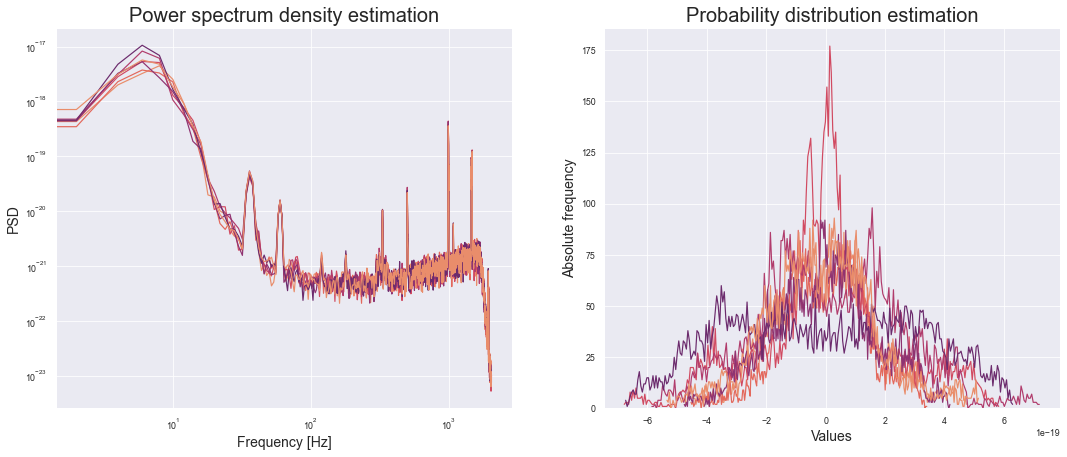

In [103]:
signal_statistics(h1_32_samples[:61000], 1 / h1_32_ts, 8192, 2048, 0.4)

#### Análisis de estacionariedad para L1

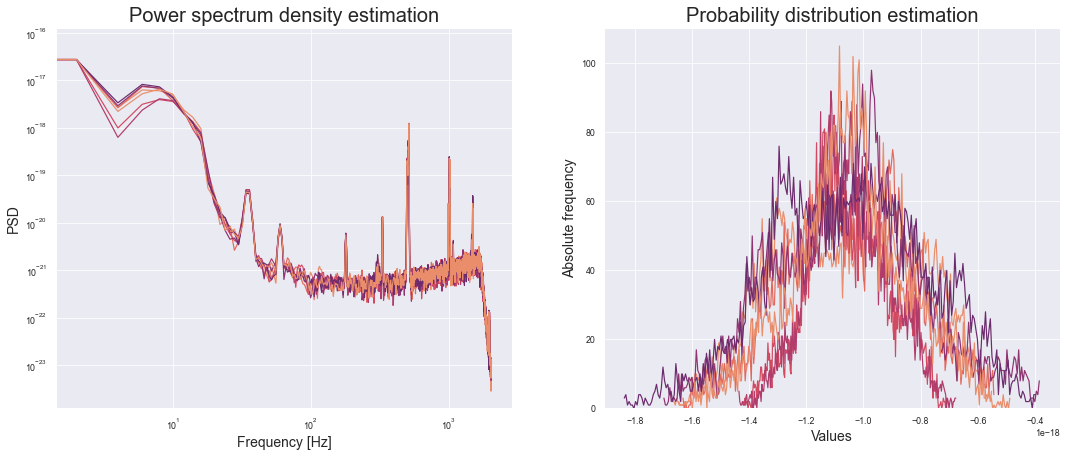

In [109]:
signal_statistics(l1_32_samples[:61000], 1 / l1_32_ts, 8192, 2048, 0.4)

### Augmented Dickey-Fuller
Si bien las estimaciones de la densidad espectral de potencia y la densidad de probabilidad se mantienen aproximadamente similares en el tiempo, la desventaja de este método gráfico es que es cualitativo, al menos siempre y cuando no se busque estimar la varianza de los estimadores para conocer qué tan cierto es que las estimaciones para diferentes instantes de tiempo no se apartan entre sí.

Existen muchos métodos disponibles para poner a prueba la estacionariedad del proceso o señal, en este caso se buscará utilizar el **Augmented Dickey-Fuller (ADF)**. Desde el punto de vista estadístico, es una **prueba de hipótesis**. Esto quiere decir que se proponen una hipótesis **nula** y una **alternativa**, y se realiza un estudio del **valor-p** para determinar si se acepta o rechaza la hipótesis nula. En este caso, la hipótesis nula es que la señal es no estacionaria, dado que posee una raíz unitaria en su modelo, y el valor-p representa la probabilidad de que dado que la señal es no estacionaria, se observen los comportamientos presentes en la señal. Por ende, si el valor-p es muy bajo, es muy poco probable que lo que se observa sea resultante de un proceso no estacionario, por ende se rechaza la hipótesis nula y se considera estacionariedad.

In [167]:
from statsmodels.tsa.stattools import adfuller

En los métodos de **Dickey-Fuller**, se pueden proponer diferentes modelos a partir de los cuáles se analiza la presencia de una raíz unitaria. Dado que la media de las señales es nula, entonces se deben descartar los modelos que presentan términos constantes.

In [165]:
print(f'La media de H1 es {h1_32_samples.mean()} y para L1 es {l1_32_samples.mean()}')

La media de H1 es -3.7594485871462737e-23 y para L1 es -1.0522364772927026e-18


In [160]:
h1_adf = adfuller(h1_32_samples, regression='nc')

In [161]:
print(f'El valor-p es {h1_adf[1]}')

El valor-p es 0.0


In [162]:
l1_adf = adfuller(l1_32_samples, regression='nc')

In [163]:
print(f'El valor-p es {l1_adf[1]}')

El valor-p es 0.01639455249773154


Finalmente, se puede observar que los valores-p para ambas pruebas de hipótesis dieron muy pequeños o nulos, y por eso se rechaza la hipótesis nula y se considera que las señales son **estacionarias**.

## Whitening

In [90]:
from scipy import interpolate

In [91]:
def whiten(x, noise_psd, ts, time_shift = 0, phase_shift = 0):
    """ Whitens strain data given the psd and sample rate, also applying a phase
        shift and time shift.
        @param x Strain data
        @param noise_psd Interpolation function of the noise estimated power spectral density
        @param ts Sampling time
        @return Whitened strain data
    """
    # Extract the amount of data
    N = len(x)
    
    # Take the fourier transform of the data
    freqs = np.fft.rfftfreq(N, ts)
    X = np.fft.rfft(x) * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    
    # Apply the whitening filter
    norm = 1. / np.sqrt(1. / (ts * 2))
    Y = X / np.sqrt(noise_psd(freqs)) * norm
    y = np.fft.irfft(Y, n=N)
    return y

In [92]:
h1_32_rpsd = h1_32_psd[0:len(h1_32_psd) // 2 + 1]
h1_32_freqs = np.linspace(0, 1 / (h1_32_ts * 2), len(h1_32_rpsd))
h1_32_psd_interpolated = interpolate.interp1d(h1_32_freqs, h1_32_rpsd)
h1_32_whitened = whiten(h1_32_samples, h1_32_psd_interpolated, h1_32_ts, time_shift=-16)

In [93]:
l1_32_rpsd = l1_32_psd[0:len(l1_32_psd) // 2 + 1]
l1_32_freqs = np.linspace(0, 1 / (l1_32_ts * 2), len(l1_32_rpsd))
l1_32_psd_interpolated = interpolate.interp1d(l1_32_freqs, l1_32_rpsd)
l1_32_whitened = whiten(l1_32_samples, l1_32_psd_interpolated, l1_32_ts, time_shift=-15)

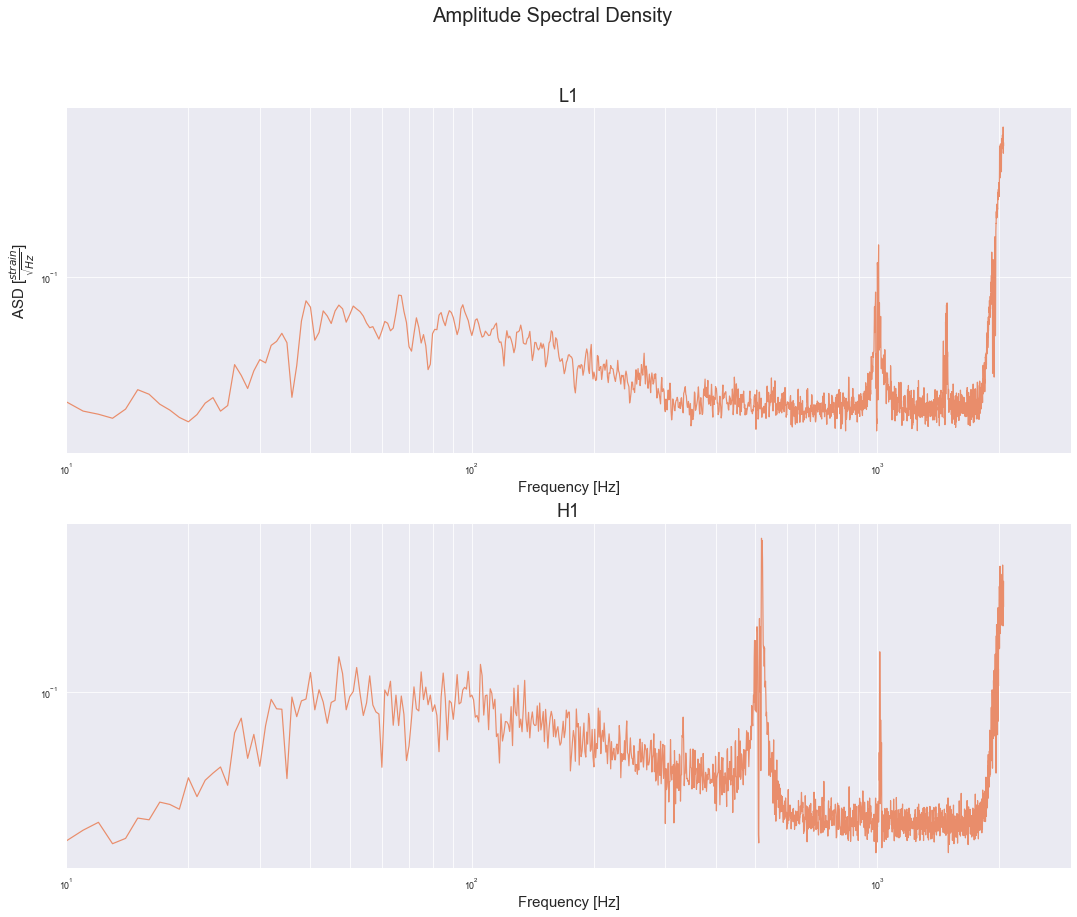

In [94]:
# Chosen estimation parameters
L = 4096
overlapping=0.4
window='hann'

# Compute and plot estimation
h1_32_whitened_psd = periodogram_averaging(h1_32_whitened, L, overlapping, window)
l1_32_whitened_psd = periodogram_averaging(l1_32_whitened, L, overlapping, window)
plot_dual_asd(h1_32_whitened_psd, l1_32_whitened_psd, 1 / h1_32_ts, 'Amplitude Spectral Density')

In [95]:
Audio(h1_32_whitened, rate=(1 / h1_32_ts), autoplay=True)

In [96]:
Audio(l1_32_whitened, rate=(1 / l1_32_ts), autoplay=True)

## Ángulo del cono de arribo

In [97]:
h1_l1_correlation = signal.correlate(h1_32_whitened, l1_32_whitened)

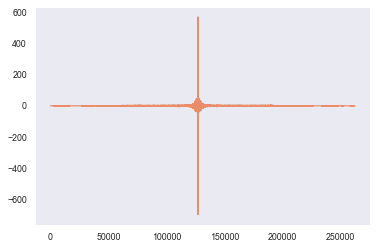

In [98]:
plt.plot(h1_l1_correlation)
plt.show()

In [99]:
len(h1_l1_correlation) // 2

131071

In [100]:
np.argmax(h1_l1_correlation)

126972

In [101]:
(131071 - 126972) * h1_32_ts

1.000732421875